# Best line fit using objects
### Irving Gomez Mendez
### March 23, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import beta, t, f

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
class slr:
    def __init__(self, dat, n0=100, alpha=0.05):
        self.p = 2
        self.n = dat.shape[0]
        self.n0 = n0
        self.alpha = alpha
        self.y = dat['y']
        self.x = dat['x']
        self.design_matrix = np.column_stack([np.ones(self.n),dat['x']])

    def OLS(self):
        results = sm.OLS(self.y,self.design_matrix).fit()
        self.results = results
        self.s2 = results.scale
        self.params = results.params

    def summary(self):
        results = self.results
        print(results.summary2())

    def plot_regression(self):
        XX = self.design_matrix
        alpha = self.alpha
        n = self.n
        p = self.p

        x0 = np.linspace(self.x.min(),self.x.max(),self.n0)
        XX0 = np.column_stack([np.ones(self.n0),x0])
        y0 = self.results.predict(XX0)

        aux_t_conf = np.sqrt(self.s2*(np.diag(XX0 @ np.linalg.solve((XX.T @ XX), XX0.T))))
        aux_t_pred = np.sqrt(self.s2*(1+np.diag(XX0 @ np.linalg.solve((XX.T @ XX), XX0.T))))
        upp_conf = y0 + t.ppf(1-alpha/2,n-p)*aux_t_conf
        low_conf = y0 - t.ppf(1-alpha/2,n-p)*aux_t_conf
        upp_pred = y0 + t.ppf(1-alpha/2,n-p)*aux_t_pred
        low_pred = y0 - t.ppf(1-alpha/2,n-p)*aux_t_pred

        plt.figure(figsize=(10,5))
        plt.plot(x0, y0, 'r', label='Fitted line')
        plt.fill_between(x0, low_pred, upp_pred, facecolor='green', alpha=0.5, label='Prediction interval')
        plt.fill_between(x0, low_conf, upp_conf, facecolor='yellow', alpha=0.5, label='Confidence interval')
        plt.scatter(self.x, self.y)
        plt.title("Estimated Regression Fucntion")
        plt.legend(loc='upper left')

    def conf_region(self, b0, b1):
        bb = np.array([b0, b1], dtype='object')
        XX = self.design_matrix
        return(1/(self.p*self.s2)*((bb-self.params).T @ XX.T @ XX @ (bb-self.params)))

    def plot_confidence_region(self):
        p = self.p
        n = self.n
        n0 = self.n0
        alpha = self.alpha
        beta_interval = self.results.conf_int(alpha=alpha)
        beta_0_interval = beta_interval.loc['const']
        beta_1_interval = beta_interval.loc['x1']

        start_beta_0 = beta_0_interval[0]-(beta_0_interval[1]-beta_0_interval[0])/6
        stop_beta_0 = beta_0_interval[1]+(beta_0_interval[1]-beta_0_interval[0])/6

        start_beta_1 = beta_1_interval[0]-(beta_1_interval[1]-beta_1_interval[0])/6
        stop_beta_1 = beta_1_interval[1]+(beta_1_interval[1]-beta_1_interval[0])/6

        beta_0_vect = np.linspace(start_beta_0,stop_beta_0,n0)
        beta_1_vect = np.linspace(start_beta_1,stop_beta_1,n0)

        z = self.conf_region(beta_0_vect[:,None], beta_1_vect[None,:])

        plt.figure(figsize=(10,5))
        plt.plot([beta_0_interval[0],beta_0_interval[1],beta_0_interval[1],beta_0_interval[0],beta_0_interval[0]],
            [beta_1_interval[0],beta_1_interval[0],beta_1_interval[1],beta_1_interval[1],beta_1_interval[0]])
        plt.contour(beta_0_vect, beta_1_vect, z, levels=[f.ppf(1-alpha, p, n-p)])
        plt.xlabel('beta_0')
        plt.ylabel('beta_1')
        plt.title("Confidence Regiona and Intervals for beta")

    def residual_analysis(self):
        self.residual_analysis = OLSInfluence(self.results).summary_frame()

    def qq_t_interval(self, k):
        n = self.n
        df = self.n-self.p
        alpha = self.alpha

        a1 = beta.ppf(alpha/2, k, n+1-k)
        a2 = beta.ppf(1-alpha/2, k, n+1-k)

        low_int = t.ppf(a1, df)
        upp_int = t.ppf(a2, df)

        return(low_int, upp_int)

    def resid_qq_plot(self):
        n = self.n
        p = self.p
        studentized_residuals = self.residual_analysis['student_resid']

        kk = np.linspace(1,n,n)
        qq_low_intervals, qq_upp_intervals = self.qq_t_interval(kk)

        fig, ax = plt.subplots(figsize=(10,5))
        fig = qqplot(studentized_residuals, line='45', ax=ax)
        plt.plot(t.ppf(kk/(n+1),df=n-1-p), qq_low_intervals, 'r--')
        plt.plot(t.ppf(kk/(n+1),df=n-1-p), qq_upp_intervals, 'r--')
        plt.title("QQ plot for Studentized Residuals")

    def resid_density_plot(self):
        n = self.n
        p = self.p
        n0 = self.n0
        studentized_residuals = self.residual_analysis['student_resid']
        ll = np.linspace(studentized_residuals.min(),studentized_residuals.max(),n0)
        t_density = t.pdf(ll,df=n-p)

        plt.figure(figsize=(10,5))
        sns.histplot(studentized_residuals, stat='density', kde=True, label='kernel estimator')
        plt.plot(ll, t_density, 'r--', linewidth=2, label='t_density')
        plt.title("Histogram and t-Density for Studentized Residuals")
        plt.legend(loc='upper left')

    def fitted_vs_resid_plot(self):
        plt.figure(figsize=(10,5))
        plt.scatter(self.results.fittedvalues,self.results.resid)
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title("Residuals vs Fitted Values")

    def resid_vs_previous_resid_plot(self):
        residuals = self.results.resid
        plt.figure(figsize=(10,5))
        plt.scatter(residuals[:-1],residuals[1:])
        plt.xlabel('Residuals_i')
        plt.ylabel('Residuals_i-1')
        plt.title("Residuals vs Previous Residuals")

    def out_resid_vs_resid_plot(self):
        residuals = self.results.resid
        h_ii = self.residual_analysis['hat_diag']
        out_residuals = residuals/(1-h_ii)

        plt.figure(figsize=(10,5))
        plt.scatter(residuals,out_residuals)
        plt.plot(residuals,residuals, 'r--')
        plt.xlabel('Residuals')
        plt.ylabel('Outer Residuals')
        plt.title("Residuals vs Outer Residuals")

    def main(self):
        self.OLS()
        self.summary()
        self.plot_regression()
        self.plot_confidence_region()
        self.residual_analysis()
        self.resid_density_plot()
        self.resid_qq_plot()
        self.fitted_vs_resid_plot()
        self.resid_vs_previous_resid_plot()
        self.out_resid_vs_resid_plot()

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.354   
Dependent Variable: y                AIC:                170.1473
Date:               2022-01-26 20:26 BIC:                172.5034
No. Observations:   24               Log-Likelihood:     -83.074 
Df Model:           1                F-statistic:        13.61   
Df Residuals:       22               Prob (F-statistic): 0.00128 
R-squared:          0.382            Scale:              64.841  
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const      33.4819    11.0983   3.0168   0.0063   10.4653   56.4984
x1          3.8458     1.0424   3.6893   0.0013    1.6839    6.0077
-----------------------------------------------------------------
Omnibus:              0.575        Durbin-Watson:           2.382
Prob(Omnibus):   

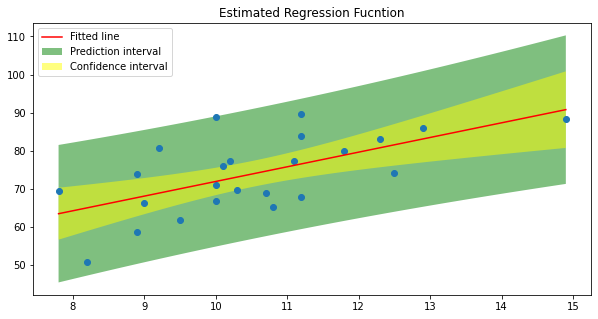

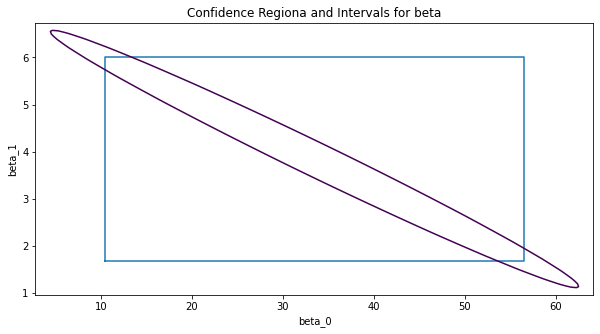

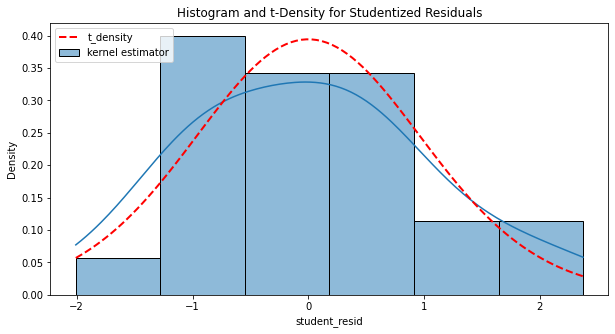

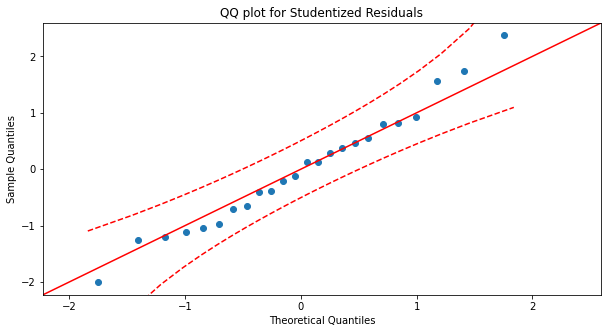

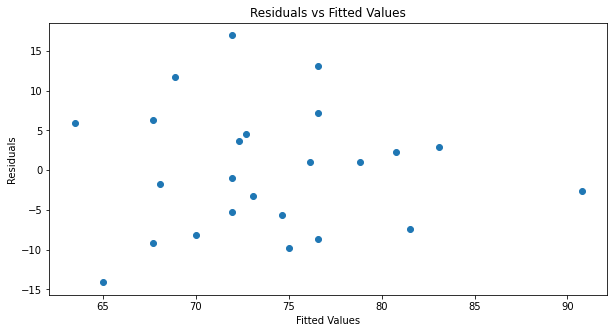

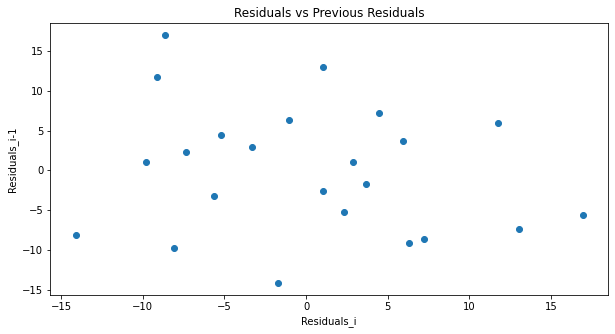

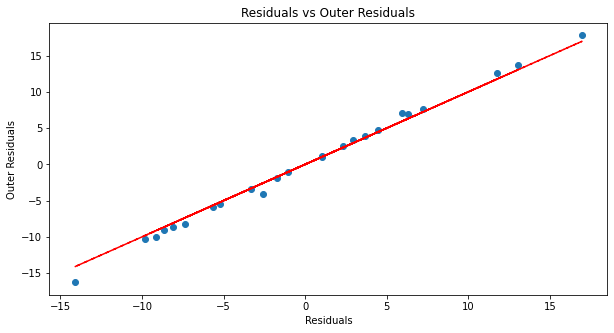

In [3]:
dat = pd.DataFrame({
    'x': [100, 89, 89, 92, 78, 101, 90, 82, 95, 108, 111, 112,125, 123, 100, 102, 112, 112, 100, 107, 103, 129, 118, 149],
    'y':[709, 740, 586, 806, 694, 760, 664, 509, 619, 652, 772, 896,742, 831, 667, 772, 838, 679, 889, 690, 698, 860, 799, 882]
    })
dat = dat/10
slr(dat).main()